## NHANES AGE PREDICTION

### Load dependencies

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot

import re
import sklearn

import plotly.graph_objs as go
import plotly.express as px
import pickle

import warnings
warnings.filterwarnings("ignore")

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [9]:
df = pd.read_csv('../cases/case_4/NHANES_age_prediction.csv')

### Take a look at data

In [10]:
df.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [11]:
df.tail()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
2273,83711.0,Adult,38.0,2.0,2.0,33.5,100.0,2.0,73.0,6.53
2274,83712.0,Adult,61.0,1.0,2.0,30.0,93.0,2.0,208.0,13.02
2275,83713.0,Adult,34.0,1.0,2.0,23.7,103.0,2.0,124.0,21.41
2276,83718.0,Adult,60.0,2.0,2.0,27.4,90.0,2.0,108.0,4.99
2277,83727.0,Adult,26.0,1.0,2.0,24.5,108.0,2.0,108.0,3.76


### Let's check what columns are actually mean

| Variable Name | Role    | Type	    | Demographic |	Description	                                                                                                                | 
| --------      | ------- | -------     | -------     | -------                                                                                                                     | 
| SEQN	        | ID	  | Continuous	|     -       | Respondent Sequence Number	                                                                                                |	
| age_group     | Targe   | Categorical	| Age         | Respondent's Age Group (senior/non-senior)	                                                                                |	
| RIDAGEYR      | Other   | Continuous	| Age	      | Respondent's Age		                                                                                                    |
| RIAGENDR      | Feature |	Continuous	| Gender	  | Respondent's Gender		                                                                                                    |
| PAQ605	    | Feature |	Continuous	|     -       | If the respondent engages in moderate or vigorous-intensity sports, fitness, or recreational activities in the typical week |
| BMXBMI	    | Feature |	Continuous	|     -       | Respondent's Body Mass Index		                                                                                        |
| LBXGLU	    | Feature |	Continuous	|     -       | Respondent's Blood Glucose after fasting		                                                                            |
| DIQ010	    | Feature |	Continuous	|     -       | If the Respondent is diabetic (0 -> Normal, 1-> High-risk, 2-> Diabetes)                                                    |
| LBXGLT	    | Feature |	Continuous	|     -       | Respondent's Oral		                                                                                                    |
| LBXIN	        | Feature |	Continuous	|     -       | Respondent's Blood Insulin Levels                                                                                           |

### And rename them into something meaningful

In [12]:
df = df.rename(columns = {
                          'RIDAGEYR': 'Age',
                          'RIAGENDR' : 'Gender',
                          'PAQ605' : 'Sport/Week',
                          'BMXBMI' : 'BMI',
                          'LBXGLU' : 'Glucose',
                          'DIQ010' : 'Diabetic',
                          'LBXGLT' : 'Oral',
                          'LBXIN' : 'Insulin',
                          }
               )


In [13]:
df.sample(5)

,SEQN,age_group,Age,Gender,Sport/Week,BMI,Glucose,Diabetic,Oral,Insulin
1216,79096.0,Adult,44.0,1.0,2.0,20.7,98.0,2.0,92.0,1.86
660,76557.0,Adult,54.0,1.0,2.0,27.8,100.0,2.0,98.0,13.04
1368,79831.0,Adult,44.0,1.0,1.0,23.7,100.0,2.0,79.0,3.93
1991,82430.0,Adult,24.0,2.0,2.0,31.1,104.0,2.0,161.0,25.46
1723,81285.0,Senior,74.0,2.0,2.0,35.5,101.0,2.0,160.0,28.76


### Encode age group to one-hot

In [14]:
df['Senior'] = df['age_group'].apply(lambda x: 1 if x == 'Senior' else 0)

### We can drop SEQN for non-informativeness and age_group to prevent data leak

In [23]:
df.drop(['SEQN'], axis=1, inplace=True)
df.drop(['age_group'], axis=1, inplace=True)
df.drop(['Age'], axis=1, inplace=True)

### Some statistics 

In [16]:
df.nunique()

Age             69
Gender           2
Sport/Week       3
BMI            340
Glucose        101
Diabetic         3
Oral           232
Insulin       1424
Senior           2
dtype: int64

In [17]:
df.isna().sum()

Age           0
Gender        0
Sport/Week    0
BMI           0
Glucose       0
Diabetic      0
Oral          0
Insulin       0
Senior        0
dtype: int64

In [18]:
df.shape

(2278, 9)

In [19]:
df.describe()

,Age,Gender,Sport/Week,BMI,Glucose,Diabetic,Oral,Insulin,Senior
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794,0.159789
std,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812,0.366491
min,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000,0.000000
25%,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000,0.000000
50%,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000,0.000000
75%,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000,0.000000
max,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000,1.000000


<Axes: >

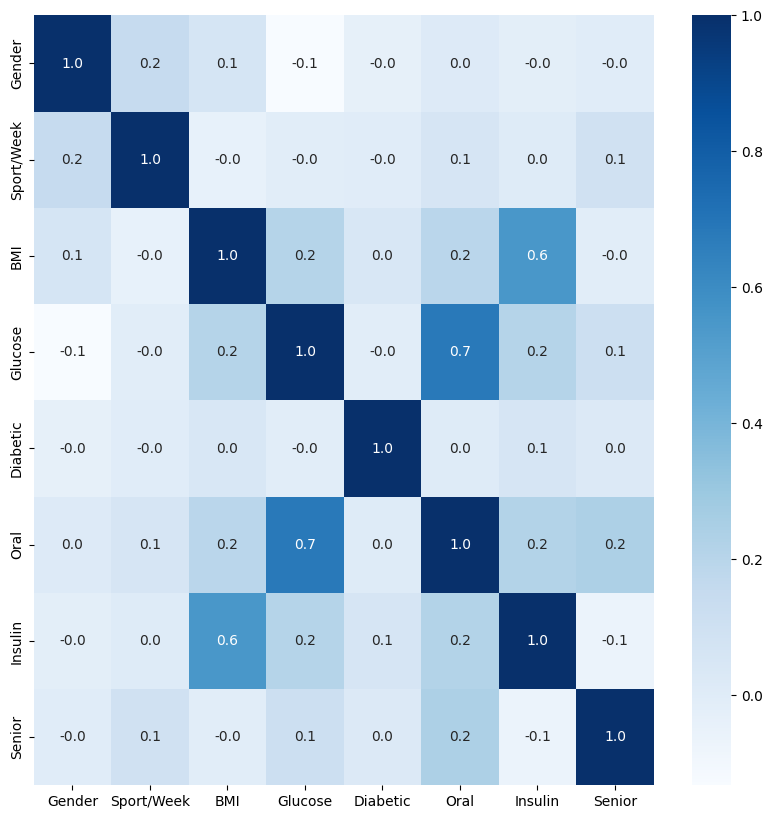

In [24]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, fmt='.1f', annot=True, annot_kws={'size':10}, cmap='Blues')

In [26]:
df.columns

Index(['Gender', 'Sport/Week', 'BMI', 'Glucose', 'Diabetic', 'Oral', 'Insulin',
       'Senior'],
      dtype='object')

#### Correlation looks not so promising

In [27]:
fig = make_subplots(rows=2, cols=4)

for i in range(8):
    fig.add_trace(go.Histogram(x=df[df.columns[i]], name=df.columns[i]), row=(i // 4) + 1, col=(i % 4) + 1)
fig.update_layout(height=800)
fig.update_traces(marker_line_width = 0)
fig.update_layout(title='Distribution of features')
fig.show()

### Now it's the model time

In [28]:
X = df.drop(['Senior'], axis=1)
y = df['Senior']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [30]:
# Scaling for logreg
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# We will use simple out of the box models
rfc = RandomForestClassifier()
cfc = CatBoostClassifier()
lgr = LogisticRegressionCV(verbose=False, refit=True)


In [32]:
%%capture
rfc.fit(X_train, y_train)
cfc.fit(X_train, y_train, verbose=False)
lgr.fit(X_train, y_train)

In [33]:
print("\ntest sample\n")

print("rfc ", classification_report(y_test, rfc.predict(X_test)))
print("cfc ", classification_report(y_test, cfc.predict(X_test)))
print("lgr ", classification_report(y_test, lgr.predict(X_test)))


test sample

rfc                precision    recall  f1-score   support

           0       0.85      0.99      0.91       375
           1       0.76      0.16      0.27        81

    accuracy                           0.84       456
   macro avg       0.80      0.57      0.59       456
weighted avg       0.83      0.84      0.80       456

cfc                precision    recall  f1-score   support

           0       0.84      0.98      0.91       375
           1       0.65      0.14      0.22        81

    accuracy                           0.83       456
   macro avg       0.74      0.56      0.57       456
weighted avg       0.81      0.83      0.79       456

lgr                precision    recall  f1-score   support

           0       0.82      1.00      0.90       375
           1       0.00      0.00      0.00        81

    accuracy                           0.82       456
   macro avg       0.41      0.50      0.45       456
weighted avg       0.68      0.82      0.74  

#### Seems legit!

#### Save models for inference

In [ ]:
with open("../models/random_forest_class.pkl", "wb") as file:
    pickle.dump(rfc, file)

with open("../models/catboost_class.pkl", "wb") as file:
    pickle.dump(cfc, file)

with open("../models/linreg.pkl", "wb") as file:
    pickle.dump(lgr, file)